In [3]:
# Generate a plot showing the long-ish term stability of the freesurface
# with and without FS forced boundaries.

In [21]:
# Stations
# Runs
import os
import pandas as pd
import xarray as xr
import numpy as np
from stompy import utils
import six
import matplotlib.gridspec as gridspec
from stompy import filters
import matplotlib.pyplot as plt
%matplotlib notebook

from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver

In [10]:
modelD1=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_006-20170610-recompile/")
modelD1.projection="EPSG:26910"
modelD2=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_006-20170620-recompile/")
modelD2.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges
INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [28]:
modelE=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_007-20170607/")
modelE.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [7]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)

True

In [11]:
start=modelD1.run_start
end  =modelD2.run_stop

def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
alameda_wl

INFO:noaa_coops:Cached   2017-06-10 00:00:00 -- 2017-06-30 00:00:00


<xarray.DataArray 'water_level' (time: 4801)>
array([1.037, 1.014, 0.992, ..., 1.688, 1.708, 1.73 ])
Coordinates:
    station  <U7 '9414750'
    lat      float64 37.77
    lon      float64 -122.3
  * time     (time) datetime64[ns] 2017-06-10 2017-06-10T00:06:00 ... 2017-06-30
Attributes:
    datum:    NAVD
    name:     NOAA Alameda

In [32]:
models=[ [modelD1,modelD2], [modelE] ]
observations=[alameda_wl]

if len(models)==1:
    model_labels=["Model"]
else:
    model_labels=[ os.path.basename(model[0].run_dir) for model in models]
    
# Extract relevant variable and location from model

base_obs=observations[0] # defines the variable and location for extracting model data
model_data=[] # a data array per model
for model in models:
    sub_parts=[]
    for sub_model in model:
        ds=sub_model.extract_station(ll=[base_obs.lon,base_obs.lat])
        if base_obs.name=='water_level':
            da=ds['eta']
            da.name='water_level' # having the same name helps later
        else:
            raise Exception("Not yet ready")
        sub_parts.append(da)
    da=xr.concat(sub_parts,dim='time')
    model_data.append(da)

# For many plots and metrics need a common timeline -- 
# Get them on common time frames
resampled=[]

def resample_and_add(da,suffix):
    df=da.to_dataframe().resample('15T').mean()
    for col in df.columns:
        df.rename({col:col+suffix},inplace=True,axis=1)
    resampled.append(df)
    return da.name+suffix

model_columns=[]
obs_columns=[]

for i,da in enumerate(model_data):
    col=resample_and_add(da,"_mod%d"%i)
    model_columns.append(col)
    
for i,da in enumerate(observations):
    col=resample_and_add(da,"_obs%d"%i)    
    obs_columns.append(col) 

combined=resampled[0]
for df in resampled[1:]:
    combined=pd.merge(combined,df,left_index=True,right_index=True)
    

<IPython.core.display.Javascript object>


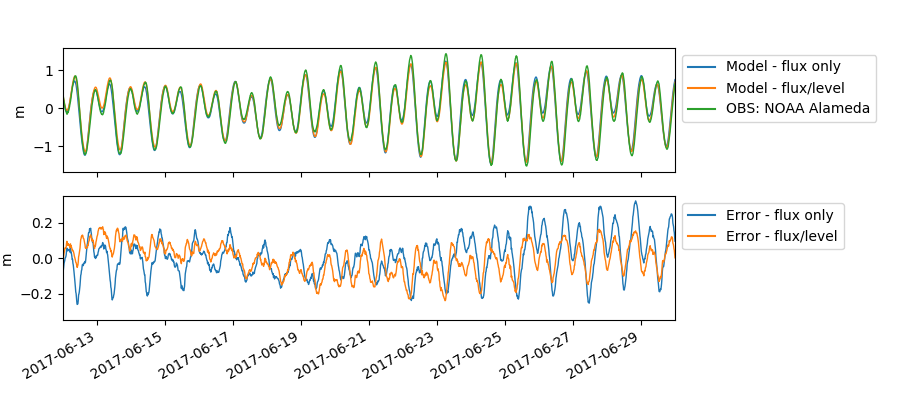

In [53]:
modelD_data=model_data[0]
modelD_mean=modelD_data.values.mean()

modelE_data=model_data[1]
modelE_mean=modelE_data.values.mean()

fig,axs=plt.subplots(2,1,sharex=True,figsize=(9,4))

ax=axs[0]
ax.plot(modelD_data.time,modelD_data.values - modelD_mean,label="Model - flux only")
ax.plot(modelE_data.time,modelE_data.values - modelE_mean,label="Model - flux/level")

obs=observations[0]
obs_mean=obs.values.mean()

ax.plot(obs.time,obs.values-obs_mean,label="OBS: %s"%obs.attrs['name'])
ax.legend(loc='upper left',bbox_to_anchor=[1,1])

axs[1].plot(combined.index.values,
            combined[model_columns[0]] - modelD_mean - combined[obs_columns[0]] + obs_mean,
            label='Error - flux only')

axs[1].plot(combined.index.values,
            combined[model_columns[1]]-modelE_mean+obs_mean-combined[obs_columns[0]],
            label='Error - flux/level')
axs[1].legend(loc='upper left',bbox_to_anchor=[1,1])

axs[0].axis(xmin=modelD_data.time.values[0]+np.timedelta64(2,"D"),
            xmax=modelD_data.time.values[-1])

axs[1].axis(ymin=-.35,ymax=0.35)

axs[0].set_ylabel('m')
axs[1].set_ylabel('m')

plt.setp(axs[0].lines,lw=1)
plt.setp(axs[1].lines,lw=1)

fig.subplots_adjust(right=0.75,left=0.07)
fig.autofmt_xdate()
fig.savefig('fs_stability.png',dpi=150)

In [35]:
combined

,water_level_mod0,water_level_mod1,lat_obs0,lon_obs0,water_level_obs0
time,,,,,
2017-06-10 00:00:00,-4.997142,-4.910525,37.7717,-122.3,1.014333
2017-06-10 00:15:00,-4.983861,-4.954806,37.7717,-122.3,0.962500
2017-06-10 00:30:00,-4.985128,-4.990798,37.7717,-122.3,0.924667
2017-06-10 00:45:00,-4.968065,-5.018975,37.7717,-122.3,0.891000
2017-06-10 01:00:00,-4.968112,-5.039748,37.7717,-122.3,0.874667
2017-06-10 01:15:00,-5.014358,-5.051892,37.7717,-122.3,0.867000
2017-06-10 01:30:00,-4.930719,-5.052667,37.7717,-122.3,0.857333
2017-06-10 01:45:00,-4.997759,-5.045627,37.7717,-122.3,0.857500
2017-06-10 02:00:00,-4.832287,-5.031547,37.7717,-122.3,0.870667


<IPython.core.display.Javascript object>


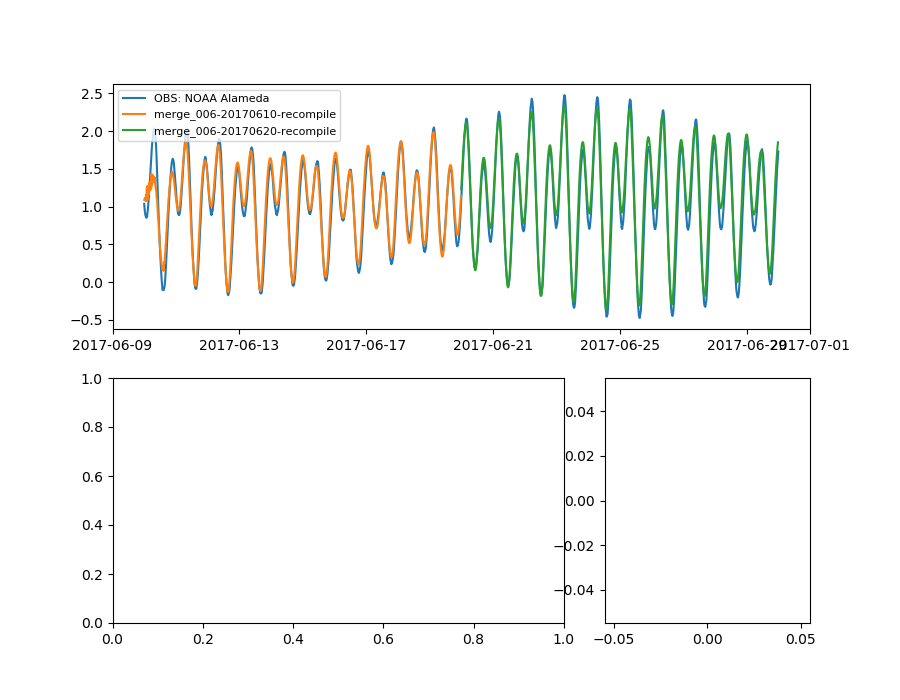

ValueError: math domain error

In [39]:

obs_mean=np.nanmean(observations[0].values)
model_mean=np.mean(model_data[0].values)

if offset_mode=='model':
    obs_offset=obs_mean-model_mean
else:
    obs_offset=0.0
if offset_mode=='obs':
    mod_offset=model_mean-obs_mean
else:
    mod_offset=0.0

if 1: # Tidal time scale plot:
    ax=ts_ax

    for obs in observations:
        ax.plot(obs.time,obs.values-obs_offset,label="OBS: %s"%obs.attrs['name'])
    for mod,mod_label in zip(model_data,model_labels):
        ax.plot(mod.time,mod.values-mod_offset,label=mod_label)
    ax.legend(fontsize=8)

# Scatter:
if 1:
    ax=scat_ax
    ax.plot(combined[obs_columns[0]],combined[model_columns[0]],'b.',ms=2)
    
# Lowpass:
if 1:
    ax=lp_ax
    t=combined.index.values
    lp_samples=36*4
    for obs_col in obs_columns:
        ax.plot(t,
                filters.lowpass_fir(combined[obs_col],lp_samples)-obs_offset,
                label='OBS')
    for mod_col,mod_label in zip(model_columns,model_labels):
        ax.plot(t, 
                filters.lowpass_fir(combined[mod_col],lp_samples)-mod_offset,
                label=mod_label)
    ax.legend(fontsize=8)
    
ts_ax.set_title(model.run_dir)
None

In [5]:

models=[modelD,modelD2]
observations=[alameda_wl]


NameError: name 'models' is not defined